In [5]:
import bz2
import json
import pandas as pd
from datetime import datetime
import numpy as np
import logging
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import vaderSentiment
import fastparquet
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import warnings
warnings.filterwarnings('ignore')

In [4]:
# If working locally :
data_path = 'data/'

# First approach of the sentiment analysis 

## Polarity scores of quotes using Vader & TextBlob

In [17]:
sid = SentimentIntensityAnalyzer()
text = "I am really extremely sad"
scores = sid.polarity_scores(text)
print(TextBlob(text).sentiment.polarity)
print(scores)

-0.5
{'neg': 0.479, 'neu': 0.521, 'pos': 0.0, 'compound': -0.5678}


## Extract only quotes from bz file (2012) for Obama

In [38]:
Obama_chunk = []
path_to_out = "obama_chunks.bz2"
with bz2.open('data/Quotebank/quotes-2012.json.bz2', 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in tqdm(s_file):
            instance = json.loads(instance) # loading a sample
            speaker = instance['speaker'] # extracting list of links
            if 'obama' in speaker:
                d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

19849872it [11:54, 27770.05it/s]


In [43]:
quotes = []
index =0
with bz2.open('obama_chunks.bz2', 'rb') as s_file:
    for ins in tqdm(s_file): 
        quotes.append([(re.findall(rb"\"speaker\":.+(?=\"qids)",ins)),(re.findall(rb"\"quotation\":.+(?=\"speaker)",ins)),(re.findall(rb"\"date\":.+(?=\"numOccurrences)",ins))])
quotes = [[quotes[i][0][0].decode(),quotes[i][1][0].decode(),quotes[i][2][0].decode()] for i in range(len(quotes))]
quotes = [[i[0][11:-2],i[1][13:-3],i[2][8:-2]] for i in quotes]
df = pd.DataFrame(quotes,  columns =['Speaker','Quote','Date'])

273984it [00:17, 16073.56it/s]


In [44]:
quotes = [[quotes[i][0][0].decode(),quotes[i][1][0].decode(),quotes[i][2][0].decode()] for i in range(len(quotes))]



In [45]:
quotes = [[i[0][11:-2],i[1][13:-3],i[2][8:-2]] for i in quotes]


In [46]:
df = pd.DataFrame(quotes,  columns =['Speaker','Quote','Date'])

In [53]:
df

,Speaker,Quote,Date
0,"""barack obama""","""a president is supposed to lead the charge to...","""2012-09-05 18:28:38"""
1,"""president obama""","""a small group of friends and aides that inclu...","""2012-08-05 04:34:08"""
2,"""barack obama""","""absolutely not. not at this age,","""2012-11-06 05:00:00"""
3,"""president obama""","""Al Qaeda has been decimated. Osama bin Laden ...","""2012-11-01 17:17:43"""
4,"""president obama""","""anytime you have a politician who has a track...","""2012-12-19 00:34:49"""
...,...,...,...
273979,"""barack obama""","""you better get your facts right","""2012-10-19 19:06:48"""
273980,"""president obama""","""you start to look and think, `are gay people ...","""2012-08-03 15:44:53"""
273981,"""president barack obama""","""your aunt betsy, who's got a real rabid appet...","""2012-09-20 18:22:46"""
273982,"""president obama""","""your loosing and its not looking like you can...","""2012-10-03 11:30:04"""


In [14]:
df['Speaker'].value_counts()[:23]

None                      138611
mitt romney                26926
president obama            13580
president barack obama     13080
barack obama                5870
rick santorum               4911
newt gingrich               4220
paul ryan                   3957
ron paul                    2493
hillary clinton             2401
david cameron               2395
chris christie              1995
joe biden                   1735
thomas more                 1666
tiger woods                 1665
john boehner                1575
scott walker                1562
vladimir putin              1508
trayvon martin              1500
whitney houston             1492
manmohan singh              1489
justin bieber               1480
tim tebow                   1406
Name: Speaker, dtype: int64

In [24]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")


KeyboardInterrupt: 

In [40]:
a = (sentiment_analysis("I love this!")[0])['score']
a

0.9988656044006348

In [62]:
def AnalyseSpeaker(speaker):
    speaker_df = df.loc[df['Speaker'].str.contains(speaker, case=False)]
    speaker_df['TextBlob'] = speaker_df.apply(lambda row: TextBlob(row.Quote).sentiment.polarity,  axis = 1)
    #speaker_df['Vader_pos'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['pos'],  axis = 1)
    #speaker_df['Vader_neg'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neg'],  axis = 1)
    speaker_df['Vader_com'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['compound'],  axis = 1)
     

    #speaker_df['Vader_neu'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neu'],  axis = 1)
    speaker_df['mean_vader_blob'] = speaker_df.apply(lambda row: np.mean([row.TextBlob, row.Vader_com]),  axis = 1)
    
    speaker_df = speaker_df.reset_index()

    
    return speaker_df


In [63]:
Obama_df = AnalyseSpeaker('obama')
mitt_df = AnalyseSpeaker('mitt romney')
hill_df = AnalyseSpeaker('hillary clinton')

In [67]:
Obama_df

,index,Speaker,Quote,Date,TextBlob,Vader_com,mean_vader_blob
0,0,"""barack obama""","""a president is supposed to lead the charge to...","""2012-09-05 18:28:38""",0.000000,0.0000,0.000000
1,1,"""president obama""","""a small group of friends and aides that inclu...","""2012-08-05 04:34:08""",-0.050000,0.4767,0.213350
2,2,"""barack obama""","""absolutely not. not at this age,","""2012-11-06 05:00:00""",-0.100000,0.0000,-0.050000
3,3,"""president obama""","""Al Qaeda has been decimated. Osama bin Laden ...","""2012-11-01 17:17:43""",-0.200000,-0.6486,-0.424300
4,4,"""president obama""","""anytime you have a politician who has a track...","""2012-12-19 00:34:49""",0.300000,0.1935,0.246750
...,...,...,...,...,...,...,...
273979,273979,"""barack obama""","""you better get your facts right","""2012-10-19 19:06:48""",0.392857,0.4404,0.416629
273980,273980,"""president obama""","""you start to look and think, `are gay people ...","""2012-08-03 15:44:53""",0.008333,-0.3570,-0.174333
273981,273981,"""president barack obama""","""your aunt betsy, who's got a real rabid appet...","""2012-09-20 18:22:46""",0.200000,0.0000,0.100000
273982,273982,"""president obama""","""your loosing and its not looking like you can...","""2012-10-03 11:30:04""",0.000000,-0.6818,-0.340900


In [75]:
test = testdf['mean_vader_blob'].resample(freq).mean()
test.plot(linewidth=0.5)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [52]:
freq = 'D'
Obama_day_mean = Obama_df['mean_vader_blob'].resample(freq).mean()
Romney_day_mean = mitt_df['mean_vader_blob'].resample(freq).mean()
Hillary_day_mean = hill_df['mean_vader_blob'].resample(freq).mean()

fig, axs = plt.subplots(3,sharex=True,figsize=(15,10))
axs[0].title.set_text('Obama sentiment Plot')
axs[1].title.set_text('Romney sentiment Plot')
axs[2].title.set_text('Hillary sentiment Plot')

Obama_day_mean.plot(linewidth=0.5,ax = axs[0])
Romney_day_mean.plot(linewidth=0.5,ax=axs[1])
Hillary_day_mean.plot(linewidth=0.5,ax=axs[2])


AttributeError: 'NaTType' object has no attribute 'tz'

In [9]:
sentiments = []
neg = []
pos = []
neu = []
com = []
min_blob_vader_pos = []
max_blob_vader_pos= []
mean_scores = []
blobscores = []
for i in tqdm(quotes):
    scores = sid.polarity_scores(i)
    neg.append(scores['neg'])
    neu.append(scores['neu'])
    pos.append(scores['pos'])
    com.append(scores['compound'])
    # adjust blobscore btw 0 and 1
    blobscore = TextBlob(i).sentiment.polarity
    blobscores.append(blobscore)
    if blobscore>0 and scores['pos']> 0:
        max_blob_vader_pos.append(max(scores['pos'],blobscore ))
        mean_scores.append(np.mean([scores['pos'],blobscore]))

    if blobscore<0 and scores['neg'] > 0:
        min_blob_vader_pos.append(max(scores['neg'],-blobscore ))
        mean_scores.append(np.mean([-scores['neg'],blobscore]))
    


  1%|▏         | 20792/1446436 [00:09<09:35, 2479.34it/s]
1445753it [01:00, 32839.28it/s][00:09<09:17, 2558.30it/s]
  4%|▍         | 64256/1446436 [00:27<09:28, 2431.16it/s]


  9%|▉         | 128033/1446436 [00:55<09:02, 2430.22it/s]


 13%|█▎        | 193290/1446436 [01:22<08:42, 2399.63it/s]


 18%|█▊        | 258239/1446436 [01:49<08:10, 2420.95it/s]


 22%|██▏       | 323211/1446436 [02:16<08:07, 2302.18it/s]


 27%|██▋       | 388519/1446436 [02:43<07:12, 2446.23it/s]


 31%|███▏      | 453736/1446436 [03:10<06:54, 2392.59it/s]


 36%|███▌      | 518642/1446436 [03:37<06:21, 2435.15it/s]


 40%|████      | 583828/1446436 [04:04<05:50, 2459.74it/s]


 45%|████▍     | 648081/1446436 [04:32<05:40, 2346.53it/s]


 49%|████▉     | 712745/1446436 [04:59<05:22, 2271.69it/s]


 54%|█████▍    | 777603/1446436 [05:26<04:50, 2304.02it/s]


 58%|█████▊    | 842086/1446436 [05:53<04:16, 2357.30it/s]


 63%|██████▎   | 907007/1446436 [06:20<03:42, 2419.02it/s]


 67%|██████▋   | 971323/1446436 [06:47<03:19, 2384.48it/s]


 72%|███████▏  | 1035357/1446436 [07:14<02:52, 2378.49it/s]


 76%|███████▌  | 1098556/1446436 [07:41<02:30, 2306.56it/s]


 80%|████████  | 1161067/1446436 [08:08<02:04, 2291.94it/s]


 85%|████████▍ | 1223360/1446436 [08:35<01:34, 2363.17it/s]


 89%|████████▉ | 1285686/1446436 [09:01<01:10, 2286.65it/s]


 93%|█████████▎| 1351966/1446436 [09:28<00:39, 2391.50it/s]


 98%|█████████▊| 1413976/1446436 [09:55<00:14, 2304.59it/s]


100%|██████████| 1446436/1446436 [10:09<00:00, 2372.74it/s]


In [36]:
import seaborn as sns

In [12]:
len(quotes)

1446436

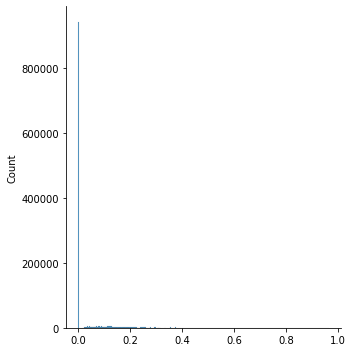

In [13]:

sns.displot(neg)

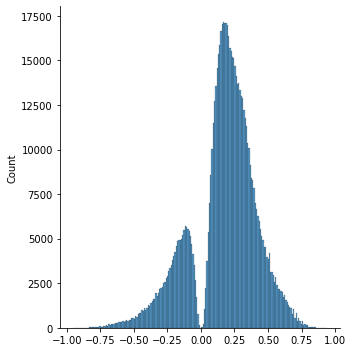

In [14]:

sns.displot(mean_scores, bins = 200)


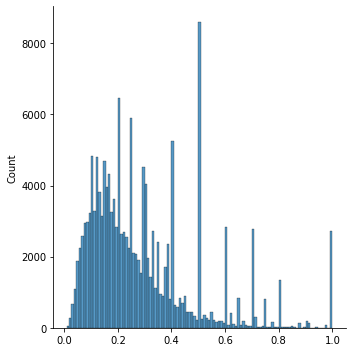

In [15]:
sns.displot(min_blob_vader_pos)

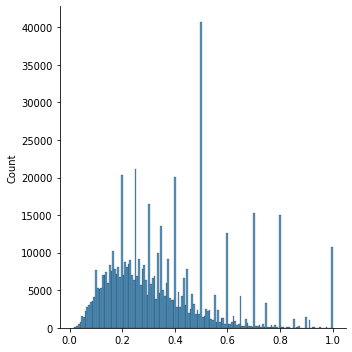

In [16]:
sns.displot(max_blob_vader_pos)

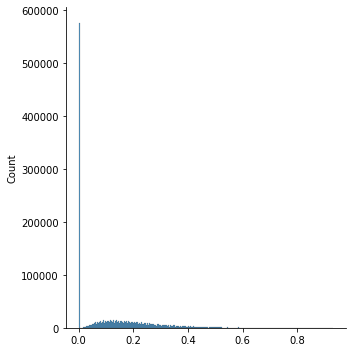

In [17]:
sns.displot(pos)

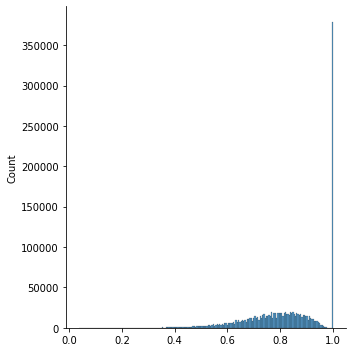

In [18]:
sns.displot(neu)

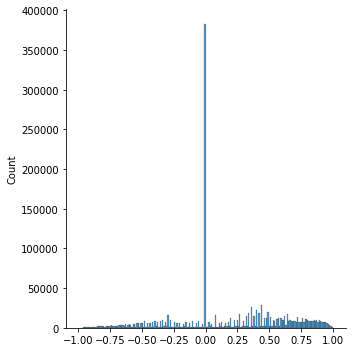

In [19]:
sns.displot(com)

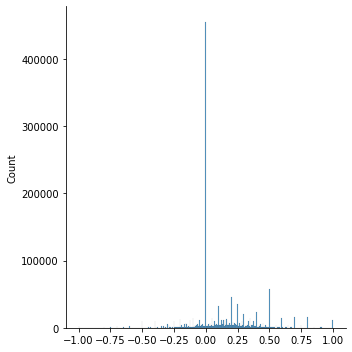

In [22]:
sns.displot(blobscores)

### MEDICAL CLUSTER PLOTS

In [2]:
# load clusters. Medical cluster is N°2
cluster = pd.read_parquet('data/cluster.parquet')

In [3]:
# create dictionnary of speakers id -> [occupations]
medical = cluster.loc[cluster['cluster']==2]
medicalIdList = medical.ID.to_list()
speaker_attributes = pd.read_parquet('data/speaker_attributes.parquet')
dict_SId_OccId = dict(zip(speaker_attributes.id, speaker_attributes.occupation))


In [ ]:
assert False
#create medical bz2 file of quotes for 2012 quotes.
path_to_out = "medical_2012.bz2"
with bz2.open('data/Quotebank/quotes-2012.json.bz2', 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in tqdm(s_file):
            #print(instance)
            instance = json.loads(instance) # loading a sample
            id_ = instance['qids']
            for quid in id_:
                occupations = dict_SId_OccId.get(str(quid))
                if (not (occupations is None)) and (set(occupations) & set(medicalIdList)):
                    #print('id:',id_,'occ:', occupations)
                    d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

In [4]:
assert False
#complete medical ds with all years 2008-2020:
for i in range(8,21):
    if i != 12:
        print("working on medical_20{:02d}.bz2".format(i))
        path_to_out = "medical_20{:02d}.bz2".format(i)
        with bz2.open("data/Quotebank/quotes-20{:02d}.json.bz2".format(i), 'rb') as s_file:
            with bz2.open(path_to_out, 'wb') as d_file:
                for instance in tqdm(s_file):
                    instance = json.loads(instance) # loading a sample
                    id_ = instance['qids']
                    for quid in id_:
                        occupations = dict_SId_OccId.get(str(quid))
                        if (not (occupations is None)) and (set(occupations) & set(medicalIdList)):
                            #print('id:',id_,'occ:', occupations)
                            d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

1705it [00:00, 17048.23it/s]

working on medical_2017.bz2


26611588it [20:49, 21298.39it/s]
2186it [00:00, 21439.54it/s]

working on medical_2018.bz2


27228451it [18:15, 24861.32it/s]
2435it [00:00, 24337.14it/s]

working on medical_2019.bz2


21763302it [15:18, 23692.29it/s]
2397it [00:00, 21191.88it/s]

working on medical_2020.bz2


5244449it [03:47, 23096.91it/s]


In [7]:
#load all medical speakers quotes from all years
quotes = []
index =0
for i in range(8,21):
    logging.info(f"loading medical file {i}")
    path_med = "data/medical_quotes/medical_20{:02d}.bz2".format(i)
    with bz2.open(path_med, 'rb') as s_file:
        for ins in tqdm(s_file): 
            quotes.append([(re.findall(rb"\"speaker\":.+(?=\"qids)",ins)),(re.findall(rb"\"quotation\":.+(?=\"speaker)",ins)),(re.findall(rb"\"date\":.+(?=\"numOccurrences)",ins))])
quotes = [[quotes[i][0][0].decode(),quotes[i][1][0].decode(),quotes[i][2][0].decode()] for i in range(len(quotes))]
quotes = [[i[0][11:-2],i[1][13:-3],i[2][8:-2]] for i in quotes]
medical_df = pd.DataFrame(quotes,  columns =['speaker','quote','date'])

4945it [00:00, 20538.22it/s]
29277it [00:01, 22343.31it/s]
23513it [00:01, 21483.92it/s]
25658it [00:01, 22199.44it/s]
26030it [00:01, 21537.82it/s]
19976it [00:00, 20532.57it/s]
18973it [00:00, 22061.54it/s]
21170it [00:01, 18936.37it/s]
12158it [00:00, 20176.42it/s]
22461it [00:01, 18206.45it/s]
23743it [00:01, 15101.94it/s]
16522it [00:00, 20782.99it/s]
4031it [00:00, 19984.02it/s]


## Pre-processsing

### expanding

In [53]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
medical_df['quote'] = medical_df['quote'].apply(lambda x:expand_contractions(x))

### Lowercase reviews:
In NLP, models treat words like Goat and goat differently, even if they are the same. Therefore, to overcome this problem, we lowercase the words. Here, I am using the lower() function available in Python for converting text to lowercase:

In [54]:
medical_df['quote']=medical_df['quote'].apply(lambda x: x.lower())

### Remove digits and words containing digits:
Next, we need to remove numbers and words containing digits from the reviews. I am doing this because digits and words containing digits do not give much importance to the main words. To do this, I am using regular expressions with lambda functions.

In [55]:
medical_df['quote']=medical_df['quote'].apply(lambda x: re.sub(r'\w*\d\w*','', x))

### Remove Punctuations:
Punctuations are the marks in English like commas, hyphens, full stops, etc. These are important for English grammar but not for text analysis. Therefore, they need to be removed:

In [57]:
import string
medical_df['quote']=medical_df['quote'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [58]:
# Removing extra spaces
medical_df['quote']=medical_df['quote'].apply(lambda x: re.sub(' +',' ',x))

In [59]:
medical_df

,speaker,quote,TextBlob,Vader_com,mean_vader_blob
date,,,,,
2008-10-08 14:54:41,"""jane seymour""",obedient in all things,0.400000,0.0000,0.200000
2008-10-28 17:23:43,"""steve chadwick""",the projects are a great example of collaborat...,0.228571,0.9260,0.577286
2008-12-19 16:05:57,"""robert ellis""",he was taken in a second two seconds no way no...,0.000000,0.5702,0.285100
2008-11-20 08:02:44,"""abdul rahman""",if you are unhappy with our woeful criminal ju...,-0.500000,-0.9246,-0.712300
2008-11-18 01:34:48,"""iris evans""",and that will be tragic,-0.750000,-0.4588,-0.604400
...,...,...,...,...,...
2020-03-17 20:41:17,"""Phillipe Nover""",this will continue until we have the ability t...,0.197619,0.6369,0.417260
2020-02-05 14:25:38,"""Mark Pearson""",with the backing of fuel ventures we are in th...,0.147619,0.9647,0.556160
2020-03-03 07:38:03,"""Rachel Robinson""",at the moment we are in the containment phase ...,0.000000,0.7650,0.382500


In [60]:
sid = SentimentIntensityAnalyzer()

def sentiment(df):
    '''
    Add to quotes dataframe df evaluations of the quote's sentiment
    '''
    df['TextBlob'] = df.apply(lambda row: TextBlob(row.quote).sentiment.polarity,  axis = 1)
    #speaker_df['Vader_pos'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['pos'],  axis = 1)
    #speaker_df['Vader_neg'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neg'],  axis = 1)
    df['Vader_com'] = df.apply(lambda row: sid.polarity_scores(row.quote)['compound'],  axis = 1)

    #speaker_df['Vader_neu'] = speaker_df.apply(lambda row: sid.polarity_scores(row.Quote)['neu'],  axis = 1)
    df['mean_vader_blob'] = df.apply(lambda row: np.mean([row.TextBlob, row.Vader_com]),  axis = 1)
    df = df.reset_index()

    
    return df

In [61]:
sentiment(medical_df)

,date,speaker,quote,TextBlob,Vader_com,mean_vader_blob
0,2008-10-08 14:54:41,"""jane seymour""",obedient in all things,0.400000,0.0000,0.200000
1,2008-10-28 17:23:43,"""steve chadwick""",the projects are a great example of collaborat...,0.228571,0.9260,0.577286
2,2008-12-19 16:05:57,"""robert ellis""",he was taken in a second two seconds no way no...,0.000000,0.5702,0.285100
3,2008-11-20 08:02:44,"""abdul rahman""",if you are unhappy with our woeful criminal ju...,-0.500000,-0.9246,-0.712300
4,2008-11-18 01:34:48,"""iris evans""",and that will be tragic,-0.750000,-0.4588,-0.604400
...,...,...,...,...,...,...
248452,2020-03-17 20:41:17,"""Phillipe Nover""",this will continue until we have the ability t...,0.197619,0.6369,0.417260
248453,2020-02-05 14:25:38,"""Mark Pearson""",with the backing of fuel ventures we are in th...,0.147619,0.9647,0.556160
248454,2020-03-03 07:38:03,"""Rachel Robinson""",at the moment we are in the containment phase ...,0.000000,0.7650,0.382500
248455,2020-03-02 16:09:01,"""Abdul Rahman""",for those who are interested a written applica...,0.250000,0.7003,0.475150


In [16]:
medical_df

,speaker,quote,TextBlob,Vader_com,mean_vader_blob
date,,,,,
2008-10-08 14:54:41,"""jane seymour""","""obedient in all things.",0.400000,0.0000,0.200000
2008-10-28 17:23:43,"""steve chadwick""","""the projects are a great example of collabora...",0.228571,0.9260,0.577286
2008-12-19 16:05:57,"""robert ellis""","""he was taken in a second. two seconds. no way...",0.000000,0.5702,0.285100
2008-11-20 08:02:44,"""abdul rahman""","""if you are unhappy with our woeful criminal j...",-0.500000,-0.9246,-0.712300
2008-11-18 01:34:48,"""iris evans""","""and that will be tragic.",-0.750000,-0.4588,-0.604400
...,...,...,...,...,...
2020-03-17 20:41:17,"""Phillipe Nover""","""This will continue until we have the ability ...",0.197619,0.6369,0.417260
2020-02-05 14:25:38,"""Mark Pearson""","""With the backing of Fuel Ventures, we're in t...",0.147619,0.9647,0.556160
2020-03-03 07:38:03,"""Rachel Robinson""","""At the moment we are in the containment phase...",0.000000,0.7650,0.382500


In [62]:
medical_df

,speaker,quote,TextBlob,Vader_com,mean_vader_blob
date,,,,,
2008-10-08 14:54:41,"""jane seymour""",obedient in all things,0.400000,0.0000,0.200000
2008-10-28 17:23:43,"""steve chadwick""",the projects are a great example of collaborat...,0.228571,0.9260,0.577286
2008-12-19 16:05:57,"""robert ellis""",he was taken in a second two seconds no way no...,0.000000,0.5702,0.285100
2008-11-20 08:02:44,"""abdul rahman""",if you are unhappy with our woeful criminal ju...,-0.500000,-0.9246,-0.712300
2008-11-18 01:34:48,"""iris evans""",and that will be tragic,-0.750000,-0.4588,-0.604400
...,...,...,...,...,...
2020-03-17 20:41:17,"""Phillipe Nover""",this will continue until we have the ability t...,0.197619,0.6369,0.417260
2020-02-05 14:25:38,"""Mark Pearson""",with the backing of fuel ventures we are in th...,0.147619,0.9647,0.556160
2020-03-03 07:38:03,"""Rachel Robinson""",at the moment we are in the containment phase ...,0.000000,0.7650,0.382500


In [10]:
#put date into datetime format
medical_df['date'] = pd.to_datetime(medical_df['date'],format="\"%Y-%m-%d %H:%M:%S\"")

In [11]:
#set date as index for plotting
medical_df.set_index('date', inplace=True)

In [ ]:
#frequency freq: D-day, W-week, M-month, Y-year...
freq = 'W'
medical_mean = medical_df['mean_vader_blob'].resample(freq).mean()
fig, axs = plt.subplots(sharex=True,figsize=(15,10))
axs.title.set_text('Medical Cluster sentiment Plot')


medical_mean.plot(linewidth=0.5,ax = axs)
